#  Example 1 - Semi Lumped Catchment Model

Model characteristics

* Catchment structure derived from DEM
* Catchment response units (within subcatchments) defined by land use
* Gridded climate data used to derive catchment average precip and PET

In this example, we'll use an Openwater model _'recipe'_ - a predefined method for generating a model structure from input data. As we'll see, we provide a few key details (data paths, model parameters) and then the model setup and simulation process proceeds automatically. Later exmamples will dive into this logic to see how customised approaches can be used.

To use the recipe, we need to provide the ingredients. In this case:

* Lists of constituents, hydrological response units and constituent generation units that will appear in each catchment
* A node link network, with corresponding catchment boundaries, which we'll generate using TauDEM
* Parameterisation data, including
  * Catchment average climate data, that we'll derive from NetCDF formatted SILO data
  * Areas of each HRU and CGU, within each subcatchment which we'll derive using zonal statistics over a land use map, and a mapping of landuse type to HRU and CGU
  * Various model parameters, applied either globally, or by HRU/CGU and/or catchment

We'll use the following, high level steps:

1. Generate subcatchments and links
2. Create a subcatchment template, describing the models to be used in each subcatchment
3. Apply the subcatchment template to each subcatchment to generate an overall graph of models representing the whole catchment
4. Parameterise the overall model with data (climate, parameters, etc)
5. Run the model
6. Explore results

In [1]:
# Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[8,8]

# Various imports we'll use to transform the data
import os
import io
import numpy as np
import pandas as pd
import netCDF4 as nc
import h5py as h5
import rasterstats
import taudem as td
import rasterio as rio
from climate_utils import zonal

# Relevant parts of openwater package
# Much of these are standard across different usages of OpenWater
import openwater.nodes as node_types
import openwater.discovery
openwater.discovery.OW_BIN=os.path.join(os.path.expanduser('~'),'src/projects/openwater')

from openwater.template import run_simulation
from openwater.discovery import discover
from openwater.config import *
from openwater.results import OpenwaterResults

# But this bit is specific to the semi-lumped catchment receipe
from openwater.catchments import SemiLumpedCatchment, delineate, build_catchment_graph



/home/joelrahman/src/projects/openwater/.owdev/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Initialise Openwater

The Openwater Python packages don't know about specific model algorithms. Rather, the Python packages rely on metadata provided by the Openwater binaries (which are implemented in Go, but individual models might be Go, C or Fortran).

The `discover()` method retrieves all such metadata and loads it into the Python package _for this session_. So this call is currently needed at the start of each script/notebook.

In [2]:
discover()

['DepthToRate',
 'EmcDwc',
 'GR4J',
 'LumpedConstituentRouting',
 'Muskingum',
 'RunoffCoefficient',
 'Sacramento',
 'Simhyd',
 'USLEFineSedimentGeneration']

## Settings

These settings are specific to the catchment being modelled OR the system you are running on (eg `td.settings.MPI_PROCESSORS`)

### Data paths and configuration

The following configuration is more about the data files used to configure the model, as well as settings for running things like TauDEM

In [3]:
# Unit conversions
SQKM_TO_SQM = 1000*1000

# System configuration
PLOT_MAPS=False                        # Controlling *this* notebook. Whether to plot a few extra maps
td.settings.MPI_PROCESSORS=6           # Number of CPU cores available to TauDEM

# Catchment / Data configuration
USER_HOME=os.path.expanduser('~')
DATA_DIR=os.path.join(USER_HOME,'Geospatial','Examples','Gippsland')

### Topography
DEM=os.path.join(DATA_DIR,'elevation.asc')

# Because we are missing project files for the ascii grids in our example, we specify the projection here using EPSG code
# We'll use this to convert the data to WGS84 for comparison with SILO
EPSG=32755

STREAM_THRESHOLD=40 # cells                          # Stream threshold (in number of cells)

### Land use
LU_GRID=os.path.join(DATA_DIR,'Landuse.asc')         # Integer grid
LAND_TYPES=os.path.join(DATA_DIR,'FUMapping.csv')    # Mapping from grid code to land use and HRU type

### Climate data
SILO=USER_HOME=os.path.join(USER_HOME,'Geospatial','SILO')
TIME_PERIOD = pd.date_range('2014/1/1','2017/12/31') # Time period for running the model

### Model file
MODEL_FN = 'gippsland.h5'
RESULTS_FN='gippsland_model_outputs.h5'


### Subcatchment structure

We define the units within the subcatchment. 

* Hydrological Response Unit (rainfall runoff),
* constituent generation units, and
* constituents

Note: One HRU maps to (possibly) multiple CGUs.

We hard code the constituents, but load the HRUs and CGUs from a file (which also maps to the grid code in the land use map)



In [4]:
# Constituents to model - constituent generation will happen for 
#             each constituent x 
#             each landuse (constituent generation unit) x 
#             each subcatchment
CONSTITUENTS=['TSS','TP','TN','C1','C2','C3','C4','C5','C6','C7']

# Hydrological response units - rainfall runoff will happen for
#             each HRU x
#             each subcatchment
# with runoff depth mapped from HRU to all relevant CGUs (with areal scaling)
#HRUS=['Forest','NonForest']#,'Nil']

# Landuses, grouped by HRU
# LANDUSES={
#     'Forest':['ManagedForest','NationalPark','Pine'],
#     'NonForest':['Urban','PeriUrban','Grazing','IrrigatedAg','DrylandAg'],
#     'Nil':['Water']
# }

# Consolidated list of landuses/CGUs
#ALL_LANDUSES=[lu for hru,lus in LANDUSES.items() for lu in lus]


In [5]:
land_types = pd.read_csv(LAND_TYPES)
land_types

,CGU,GRID,HRU
0,Horticulture,1,Non-Forest
1,Irrigated Grazing,2,Non-Forest
2,Public Land,3,Non-Forest
3,Forest,4,Forest
4,Dryland,5,Non-Forest
5,Plantation,6,Forest
6,Rural Residential,7,Non-Forest
7,Water/lakes,8,Water
8,Urban,9,Non-Forest
9,Urban,10,Non-Forest


In [6]:
HRUS = list(set(land_types.HRU))  # List of hydrological response units
CGUS = list(set(land_types.CGU)) # List of ALL CGU types

# Lookup of CGU type to HRU type, used to transfer runoff fluxes to constituent generation models
CGU_HRU = {cgu:list(land_types[land_types.CGU==cgu]['HRU'])[0] for cgu in CGUS}

### Model choices

Finally, we can configure which model algorithms to use for each process.

Here, we specify Simhyd as the Rainfall Runoff model, to be used for all HRUs in all subcatchments.

It is also possible to specify models that apply to any specific unit or groups of units.

In [7]:
# Model configuration`

RR = node_types.Simhyd

## Catchment generation

The `delineate` method wraps up the TauDEM catchment generation process, based on a DEM and a stream threshold

In [8]:
tree, watersheds_poly, streams, coords, order = delineate(DEM,STREAM_THRESHOLD)

In [9]:
# Because the TauDEM results lack projection info (because the source data also lacked it), we initialise the projection info:
watersheds_poly.crs = {'init':'EPSG:%d'%EPSG}

In [10]:
if PLOT_MAPS:
    watersheds_poly.plot('GRIDCODE')

In [11]:
# Now, we convert to WGS84 to align with SILO
watersheds_wgs84 = watersheds_poly.to_crs(epsg=4326)

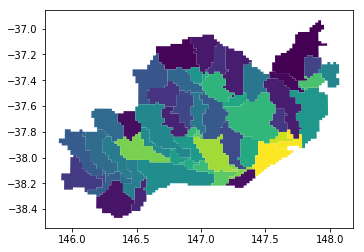

In [12]:
watersheds_wgs84.plot('GRIDCODE')

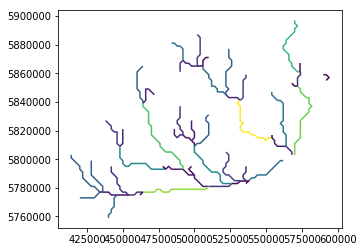

In [13]:
streams.plot('LocalArea')

In [14]:
len(streams)

58

In [15]:
# tree is a DataFrame describing the topology
tree[:10]

,Link_Number,Index_Start_Point,Index_End_Point,Link_DS,Link_US1,Link_US2,Strahler_Order,Monitoring_Point_DS,Network_Magniture
0,55,0,2,61,49,6,2,-1,3
1,0,3,22,67,-1,-1,1,-1,1
2,6,23,34,55,-1,-1,1,-1,1
3,49,35,40,55,31,1,2,-1,2
4,31,41,45,49,-1,-1,1,-1,1
5,19,46,49,67,-1,-1,1,-1,1
6,13,50,54,61,-1,-1,1,-1,1
7,1,55,63,49,-1,-1,1,-1,1
8,56,64,69,62,61,7,2,-1,5
9,61,70,83,56,55,13,2,-1,4


In [16]:
# For example, we can find all the headwater catchments - they have -1 as their upstream links
tree[tree.Link_US1==-1]

,Link_Number,Index_Start_Point,Index_End_Point,Link_DS,Link_US1,Link_US2,Strahler_Order,Monitoring_Point_DS,Network_Magniture
1,0,3,22,67,-1,-1,1,-1,1
2,6,23,34,55,-1,-1,1,-1,1
4,31,41,45,49,-1,-1,1,-1,1
5,19,46,49,67,-1,-1,1,-1,1
6,13,50,54,61,-1,-1,1,-1,1
7,1,55,63,49,-1,-1,1,-1,1
11,7,90,106,56,-1,-1,1,-1,1
12,25,107,120,44,-1,-1,1,-1,1
13,43,121,124,-1,-1,-1,1,-1,1
14,37,125,134,62,-1,-1,1,-1,1


## Configure the template catchment

The semi-lumped catchment _recipe_ works by having a template subcatchment, duplicating the template for each subcatchment and then linking the subcatchments using the generated topology. The template represents all the HRUs, CGUs and constituents, with the appropriate model choices.

We've defined the constituents, HRUs and CGUs above, along with the mapping between HRU and CGU.

We also specified Simhyd as the rainfall runoff model.

Here we create the template and apply all those settings. We'll leave other settings at the default.

In [17]:
catchment_template = SemiLumpedCatchment()

In [18]:
catchment_template.hrus = HRUS
catchment_template.cgus = CGUS
catchment_template.cgu_hrus = CGU_HRU
catchment_template.constituents = CONSTITUENTS

In [19]:
catchment_template.rr = RR
catchment_template.rr

Openwater Model Description: Simhyd

In [20]:
catchment_template.cg

Openwater Model Description: EmcDwc

In [21]:
catchment_template.routing

Openwater Model Description: Muskingum

In [22]:
catchment_template.transport

Openwater Model Description: LumpedConstituentRouting

## Assembling the model structure

The subcatchment template is the first thing provided by the semi-lumped _recipe_. A way of linking templates is the second.

This can take a while on large systems (many catchments and/or spatial units)

In [23]:
%time model = build_catchment_graph(catchment_template,streams)

CPU times: user 4.51 s, sys: 27.5 ms, total: 4.54 s
Wall time: 4.57 s


In [24]:
# Number of model instances to be run
len(model.sequence)

9860

### Aside: Why does the assembly take some time?

When we call `build_catchment_graph` it assembles all the catchments and then links them together. THEN, it **schedules** each and every component model.

OpenWater will run each component model in batches, such that models that run in batch _n_, can require outputs of models up to and including batch _n-1_.

The scheduling is an iterative process and attempts to avoid large number of batches with few models. The iteration moves models between batches where there is flexibility as to when that model can run. For example, ALL rainfall runoff models in all HRUs and subcatchments COULD run in the very first batch. But the rainfall runoff models for subcatchments towards the bottom of the system could be delayed until a later batch, because the runoff will ultimately feed into a routing model that can't run until its upstream models have run.

The following cell shows the distribution of model runs between batches


[21, 276, 1162, 1386, 1481, 1364, 1276, 959, 658, 481, 347, 298, 141, 10]


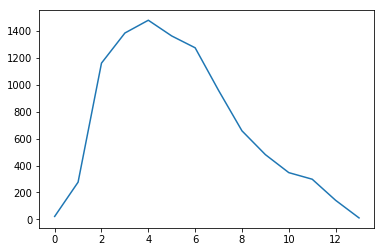

In [25]:
stage_lengths = [len(s) for s in model.order]
plt.plot(stage_lengths,label='sl')
# plt.plot(old_stage_lengths,label='old')
# plt.legend()
print(stage_lengths)

## Parameterising the model

We now have a model assembled covering the whole catchment, with the same structure within each subcatchment.

However there are no input time series in the model, and all parameters are set to 0.

Broadly, input time series and model parameters are handled in the same way:

* At the time of writing the model structure to disk, in order to run a simulation, we provide a list of parameterisation objects.
* Then, the model structure is written out, one model type at a time (eg all SimHyds, then all EMCDWC models, etc).
* For each model type, each parameterisation object is offered to chance to act.
* The parameterisation object can pass (ie do nothing) or act.

A parameterisation object would pass if, for example, its configured to work on SimHyd and asked to operate on Muskingum models, or if it doesn't have any relevant values for the model in question.

OpenWater contains a number of parameterisation components and its expected that some users will need to write their own. That said, at the moment at least, the parameterisation components tend to lookup values in precomputed tables, with the actual computation happening beforehand.


In [26]:
# Construct the Parameteriser and assign it to the model.
p = Parameteriser()
model._parameteriser = p

In this example, we'll apply
* Time series inputs to the rainfall runoff models (Rainfall + PET) on a per subcatchment basis.
* Assign Event Mean Concentrations and Dry Weather Concentrations for each constituent on a per landuse (CGU) type basis
* Set sensible default parameters for various models (noting that any parameter we don't touch will be 0)

Also, we need to specify the areas of different land uses as part of the parameterisation step.

Broadly, for each of the above, we will:

* Compute the values we need - using existing Python packages
* Configure a parameterisation object with the values
* Append the parameterisation object to the overal list of paramaterisers

### Climate Data

We will compute subcatchment average rainfall and PET using SILO data and the `climate_utils` package.

The result of `zonal.compute_catchment_time_series` is a dataframe, with one column per subcatchment, names for the subcatchment

In [27]:
rainfall = zonal.compute_catchment_time_series('daily_rain',
                                               watersheds_wgs84,
                                               TIME_PERIOD,
                                               data_loader = zonal.netcdf_loader(os.path.join(SILO,'${year}.${variable}.nc'),watersheds_wgs84),
                                               name_attribute='GRIDCODE',
                                               column_naming='${catchment}',
                                               percent_cover_scale=20,
                                               show_progress=True)

pet = zonal.compute_catchment_time_series('et_morton_wet',
                                           watersheds_wgs84,
                                           TIME_PERIOD,
                                           data_loader = zonal.netcdf_loader(os.path.join(SILO,'${year}.${variable}.nc'),watersheds_wgs84),
                                           name_attribute='GRIDCODE',
                                           column_naming='${catchment}',
                                           percent_cover_scale=20,
                                           show_progress=True)



2014 1 

/home/joelrahman/src/forks/python-rasterstats/src/rasterstats/main.py:241: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


2 3 4 5 6 7 8 9 10 11 12 
2015 1 2 3 4 5 6 7 8 9 10 11 12 
2016 1 2 3 4 5 6 7 8 9 10 11 12 
2017 1 2 3 4 5 6 7 8 9 10 11 12 
2014 1 2 3 4 5 6 7 8 9 10 11 12 
2015 1 2 3 4 5 6 7 8 9 10 11 12 
2016 1 2 3 4 5 6 7 8 9 10 11 12 
2017 1 2 3 4 5 6 7 8 9 10 11 12 

Now we construct a `DataframeInputs` object that takes dataframes of time series and applies them to a model structure.

The line

```
i.inputter(rainfall,'rainfall','${catchment}')
```
  
registers a new DataFrame (rainfall) and applies it to an input (also rainfall).

The `'${catchment}'` parameter specifies how to lookup a column name based on the dimensions relevant for the model. In this case, The collection of SimHyd models will have two dimensions: catchment x HRU, but we only need catchment to select the rainfall.

In [28]:
i = DataframeInputs()
i.inputter(rainfall,'rainfall','${catchment}')
i.inputter(pet,'pet','${catchment}')

p._parameterisers.append(i)


### EMCs and DWCs

We will now configure the constituent generation parameters - EMC and DWC.

These will be set on a per landuse basis, with the same parameters applying across different subcatchments.

I've embedded the EMC data in the notebook as a CSV string, which we convert to a DataFrame

In [29]:
emcs='''lu,TSS,TP,TN,C1,C2,C3,C4,C5,C6,C7
Water/lakes,0,0,0,0,0,0,0,0,0,0
Horticulture,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Irrigated Grazing,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Industry,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Public Land,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Plantation,50,2,5,0.1,0.2,0.3,0.4,0.5,0.6,0.7
Rural Residential,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Dryland,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Urban,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Irrigation,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Mine/Quarry,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Forest,50,2,5,0.1,0.2,0.3,0.4,0.5,0.6,0.7
'''
emcs = pd.read_csv(io.StringIO(emcs),index_col=0)
emcs

,TSS,TP,TN,C1,C2,C3,C4,C5,C6,C7
lu,,,,,,,,,,
Water/lakes,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Horticulture,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Irrigated Grazing,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Industry,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Public Land,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Plantation,50,2,5,0.1,0.2,0.3,0.4,0.5,0.6,0.7
Rural Residential,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Dryland,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5
Urban,125,30,5,0.2,0.5,1.0,1.5,1.8,2.2,2.5


In [30]:
# For simplicity, I'm making DWCs 30% of the EMC
dwcs = emcs * 0.3
dwcs

,TSS,TP,TN,C1,C2,C3,C4,C5,C6,C7
lu,,,,,,,,,,
Water/lakes,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Horticulture,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Irrigated Grazing,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Industry,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Public Land,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Plantation,15.0,0.6,1.5,0.03,0.06,0.09,0.12,0.15,0.18,0.21
Rural Residential,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Dryland,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75
Urban,37.5,9.0,1.5,0.06,0.15,0.30,0.45,0.54,0.66,0.75


Now, we can add these tabls into the parameterisation using `ParameterTableAssignment`

The line

```
emc_params = ParameterTableAssignment(emcs,'EmcDwc','EMC','constituent','cgu')
```

Sets up a parameteriser based on the `emcs` DataFrame. It applies to models of type `EmcDwc` and the parameter `EMC`.

`constituent` and `cgu` both relate to the dimensions of the EmcDwc model. In this notebook, the EmcDwc model will be applied for every constituent in every CGU in every subcatchment - three dimensions. But we only need constituent and CGU as we're applying the same parameters for each subcatchment.

In this case, `constituent` specifies the columns and `cgu` specifies the rows.


In [31]:
emc_params = ParameterTableAssignment(emcs,'EmcDwc','EMC','constituent','cgu')
dwc_params = ParameterTableAssignment(dwcs,'EmcDwc','DWC','constituent','cgu')

p._parameterisers.append(emc_params)
p._parameterisers.append(dwc_params)

### Default parameters

We need to explicitly set default parameters, eg for rainfall runoff. Any parameters we don't explicitly set will stay as 0.

`DefaultParameteriser` takes a model name and a links of parameter values

In [32]:
p._parameterisers.append(DefaultParameteriser('Simhyd',baseflowCoefficient=0.1,imperviousThreshold=1,
                                              infiltrationCoefficient=30,infiltrationShape=2,
                                              interflowCoefficient=0.2,perviousFraction=0.9,
                                              rainfallInterceptionStoreCapacity=1,rechargeCoefficient=0.3,
                                              soilMoistureStoreCapacity=350))

p._parameterisers.append(DefaultParameteriser('RunoffCoefficient',coeff=0.5))
p._parameterisers.append(DefaultParameteriser('DepthToRate',DeltaT=86400.0,area=0.0))
p._parameterisers.append(DefaultParameteriser('Muskingum',DeltaT=86400.0,K=15000,X=0.5))


### Land use areas

Importantly, we need to specify the areas of landuses. Otherwise they'll all stay 0 and nothing will come out of the catchment.

The computation is a little involved. We use `zonal_stats` to clip out each catchment from the landuse grid as individual rasters. We then sum up the area of each grid code in each subcatchment and translate the code to the appropriate CGU.

We end with a DataFrame of subcatchment number (columns) x CGU type (rows)

In [33]:

lu = rio.open(LU_GRID)
lu_data = lu.read()
areal_stats = rasterstats.zonal_stats(watersheds_poly,
                                      lu_data[0],
                                      affine=lu.transform,
                                      raster_out=True,
                                      percent_cover_weighting=True,
                                      percent_cover_scale=10)
area_lookup = {}
CELL_AREA = 2*2*SQKM_TO_SQM
for grid_code, areas in zip(list(watersheds_poly.GRIDCODE),areal_stats):
    mini = areas['mini_raster_array']
    weight = areas['mini_raster_percent_cover']
    catchment_areas = {}
    codes = [u for u in np.unique(mini) if u != np.ma.core.MaskedConstant] 
    for code in codes:
        coords = np.where(mini==code)
        weights = weight[coords[0],coords[1]]
        total_weight = sum(weights)
        cgu = land_types.CGU[land_types.GRID==code].iloc[0]
        if not cgu in catchment_areas:
            catchment_areas[cgu] = 0
        catchment_areas[cgu] += total_weight * CELL_AREA
    area_lookup[grid_code] = catchment_areas
area_lookup = pd.DataFrame(area_lookup).fillna(0.0)
area_lookup


/home/joelrahman/src/forks/python-rasterstats/src/rasterstats/main.py:206: UserWarning: `all_touched` was not enabled but an option requiring percent_cover calculations was selected. Automatically enabling `all_touched`.
  warnings.warn('`all_touched` was not enabled but an option requiring '
/home/joelrahman/src/forks/python-rasterstats/src/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/joelrahman/src/forks/python-rasterstats/src/rasterstats/main.py:241: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


,0,1,2,3,4,5,6,7,8,9,...,69,70,75,76,81,82,87,88,93,94
Dryland,3.308000e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.052400e+08,3.156000e+08,0.000000e+00,5.640000e+07,9.996000e+07,0.000000e+00,...,1.320000e+07,7.436000e+07,6.560000e+07,8.400000e+06,3.092000e+08,0.0,5.836000e+07,0.0,8.236000e+07,1.944400e+08
Forest,5.267600e+08,5.611200e+08,1.792000e+08,2.703600e+08,1.908000e+07,1.083600e+08,4.023600e+08,4.567600e+08,5.059600e+08,2.751600e+08,...,4.000000e+06,8.000000e+06,4.084000e+08,0.000000e+00,2.080000e+07,0.0,0.000000e+00,0.0,4.000000e+05,9.516000e+07
Horticulture,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Industry,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.400000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Irrigated Grazing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+06,0.000000e+00,...,4.000000e+05,0.000000e+00,8.000000e+06,0.000000e+00,0.000000e+00,0.0,4.000000e+05,0.0,4.000000e+06,4.000000e+06
Irrigation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.000000e+06,1.200000e+07,0.000000e+00,0.000000e+00,1.303600e+08,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Mine/Quarry,4.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.240000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Plantation,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.000000e+06,0.000000e+00,0.000000e+00,8.000000e+05,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Public Land,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.200000e+07,0.000000e+00,0.000000e+00,4.000000e+05,0.0,4.000000e+06,0.0,0.000000e+00,0.000000e+00
Rural Residential,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+04,4.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+05,0.0,8.000000e+06,0.0,4.000000e+06,7.600000e+05


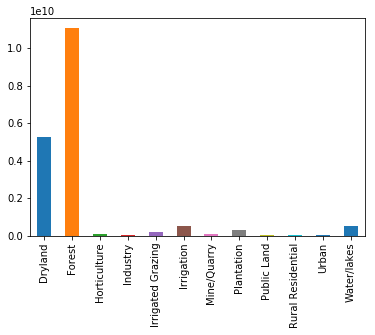

In [34]:
# Plot an overal distribution of the landuse / CGU areas
area_lookup.transpose().sum().plot.bar()

Now we have the land use areas, we can assign them to the appropriate parameters in the model.

To do so, we need to know where CGU area is used as a model parameter. As it turns out, it is used as a parameter to the `DepthToRate` model that we use to scale runoff outputs to CGU inputs (and also as inflow to reach routing).

So, we can construct a `ParameterTableAssignment` as we did for the EMCs and DWCs:

In [35]:
aa = ParameterTableAssignment(area_lookup,'DepthToRate','area','catchment','cgu')

p._parameterisers.append(aa)



**Note:** `DepthToRate` is a simple operation, but it is just like any other model. In this case, it sits between the runoff component of the HRU and the generation component of the CGUs.

There are actually three dimensions of `DepthToRate` models in this setup:
   * each catchment x 
   * each CGU x
   * three runoff components (quickflow, baseflow, total)
   
By sepcifying `'catchment'` and `'cgu'` as the dimensions in the `ParameterTableAssignment` we ensure that the same scaling factor is applied to each runoff component.


We can now see that we have eight parameterisers that will be used when the model is written to disk

In [36]:
p._parameterisers

## Write to disk and run simulation.

The OpenWater simulation engine is an executable, written in Go.

At the moment, we need to write the model out to disk in order to run the simulation.


In [37]:
if os.path.exists(MODEL_FN):
    os.remove(MODEL_FN)
model.write_model(MODEL_FN,len(TIME_PERIOD))

==== Called for Simhyd ====
['rainfall', 'pet']
<HDF5 group "/MODELS/Simhyd" (5 members)>
{'hru': ['Forest', 'Non-Forest', 'Water'], 'catchment': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38, 39, 40, 43, 44, 45, 46, 49, 50, 51, 52, 55, 56, 57, 58, 61, 62, 63, 64, 67, 69, 70, 75, 76, 81, 82, 87, 88, 93, 94]}
('55-RR-Forest (Simhyd)', {'hru': 'Forest', '_process': 'RR', '_model': 'Simhyd', 'catchment': 55, '_generation': 2, '_run_idx': 66})
(3, 58)

Processing 55-RR-Forest (Simhyd)
Processing 82-RR-Non-Forest (Simhyd)
Applying default parameters: Simhyd
[{'Name': 'baseflowCoefficient', 'Default': 0, 'Description': '', 'Range': [0, 0], 'RangeOpen': [False, False], 'Units': ''}, {'Name': 'imperviousThreshold', 'Default': 0, 'Description': '', 'Range': [0, 0], 'RangeOpen': [False, False], 'Units': ''}, {'Name': 'infiltrationCoefficient', 'Default': 0, 'Description': '', 'Range': [0, 0], 'RangeOpen': [False, False], 'Units': ''}, {

In [38]:
run_simulation(MODEL_FN,RESULTS_FN,overwrite=True)


0

## Retrieve results

The results should be written to a HDF5 file now.

We have some functionality for interrogating the results.

Again, this functionality is based around the 'dimensions' of various models - eg catchment, HRU, CGU, constituent etc.

To use the results functionality we need both the model file and the results file.

In [39]:
results_f = h5.File(RESULTS_FN,'r')
inputs_f = h5.File(MODEL_FN)
results = OpenwaterResults(inputs_f,results_f,TIME_PERIOD)

The results object can return tables and time series.

In each case we need to specify a model of interest and a variable which is either an input or an output.


In [40]:
results.time_series?

Signature: results.time_series(model, variable, columns, aggregator=None, **kwargs)
Docstring:
Return a table (DataFrame) of time series results from the model.

Parameters:

* model - the model of interest
* variable - a variable on the model, either an input or an output
* columns - a dimension of the model to use as the columns of the DataFrame
* aggregator - a function name (string) to apply when more than one data series matches a particular column (eg 'mean')
* **kwargs - used to specify other dimensions to filter by

For aggregator, see agg_fns.keys()

For dimensions (row, columns and kwargs), see dims_for_model
File:      ~/src/projects/openwater/py/openwater/results.py
Type:      method


In [41]:
results.table?

Signature: results.table(model, variable, rows, columns, temporal_aggregator='mean', aggregator=None, **kwargs)
Docstring:
Return a table (DataFrame) of aggregated model results from the model.

Parameters:

* model - the model of interest
* variable - a variable on the model, either an input or an output
* row - a dimension of the model to use as the rows of the DataFrame
* columns - a dimension of the model to use as the columns of the DataFrame
* temporal_aggregator - a function name (string) to reduce the timeseries results to a single value (default='mean')
* aggregator - a function name (string) to apply when more than one data series matches a particular row/column (eg 'mean')
* **kwargs - used to specify other dimensions to filter by

For temporal_aggregator, see temporal_agg_fns.keys()

For aggregator, see agg_fns.keys()

For dimensions (row, columns and kwargs), see dims_for_model
File:      ~/src/projects/openwater/py/openwater/results.py
Type:      method


For example, we can compute time series of catchment average runoff (and rainfall) as follows.

Out columns will be catchment and we'll aggregate the other dimensions (HRUs) by taking the mean

In [42]:
catchment_runoff = results.time_series('Simhyd','runoff','catchment','mean')#,hru='Forest')
catchment_runoff[:10]

,0,1,2,3,4,5,6,7,8,9,...,69,70,75,76,81,82,87,88,93,94
2014-01-01,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-02,0.0,0.464584,0.0,0.153032,0.000000,0.498307,0.453083,0.054773,0.0,0.000000,...,0.000000,4.723973e-03,0.042007,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-03,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-04,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-05,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-06,0.0,0.088164,0.0,0.219913,0.028457,0.622686,0.000000,0.000000,0.0,0.012582,...,0.015369,4.038070e-02,0.530786,0.010656,0.0,0.01,0.0,0.01,0.0,0.0
2014-01-07,0.0,0.000247,0.0,0.000206,0.000000,0.001865,0.000000,0.000000,0.0,0.000000,...,0.000000,1.179083e-06,0.000138,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-08,0.0,0.000222,0.0,0.000186,0.000000,0.001678,0.000000,0.000000,0.0,0.000000,...,0.000000,1.061175e-06,0.000124,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-09,0.0,0.000200,0.0,0.000167,0.000000,0.001510,0.000000,0.000000,0.0,0.000000,...,0.000000,9.550575e-07,0.000111,0.000000,0.0,0.00,0.0,0.00,0.0,0.0
2014-01-10,0.0,0.148819,0.0,0.000150,0.000000,0.001359,0.075477,0.000000,0.0,0.000000,...,0.000000,8.595518e-07,0.000100,0.000000,0.0,0.00,0.0,0.00,0.0,0.0


The same works transparently for model inputs

In [43]:
catchment_rainfall = results.time_series('Simhyd','rainfall','catchment','mean')#,hru='Forest')
catchment_rainfall[:10]

,0,1,2,3,4,5,6,7,8,9,...,69,70,75,76,81,82,87,88,93,94
2014-01-01,0.000000,0.151360,0.000000,0.027541,0.000000,0.158937,0.025106,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2014-01-02,0.073810,5.645843,0.506212,2.530318,0.889724,5.983067,5.530830,1.547733,0.688002,0.040428,...,0.302765,1.047240,1.420065,0.868340,0.391196,0.8,0.592914,0.8,0.612033,0.637367
2014-01-03,0.000000,0.018596,0.000000,0.044447,0.000000,0.133744,0.009267,0.000000,0.000000,0.000764,...,0.000000,0.000000,0.054262,0.000000,0.000000,0.0,0.042580,0.0,0.045939,0.076005
2014-01-04,0.000000,0.000000,0.000000,0.011129,0.000000,0.375747,0.024546,0.025364,0.000000,0.000000,...,0.000000,0.000000,0.027187,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2014-01-05,0.000000,0.000000,0.000000,0.054344,0.000000,0.799452,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.072600,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2014-01-06,0.112872,1.860588,0.354592,3.181549,1.284570,7.067667,0.829164,0.921458,0.521569,1.125824,...,1.153687,1.403707,6.296145,1.106557,0.511322,1.1,0.361698,1.1,0.387194,0.638563
2014-01-07,0.000000,0.260849,0.000000,0.506135,0.000000,0.779239,0.338128,0.126050,0.000000,0.030714,...,0.038710,0.000000,0.534585,0.000000,0.001037,0.0,0.000000,0.0,0.000000,0.000000
2014-01-08,0.000000,0.003351,0.000000,0.144089,0.000000,0.026346,0.103074,0.031471,0.000000,0.000764,...,0.000000,0.000000,0.102191,0.000000,0.000000,0.0,0.042580,0.0,0.042157,0.085447
2014-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2014-01-10,0.003960,2.448324,0.026739,0.429400,0.188936,0.082160,1.739067,0.577145,0.008189,0.002161,...,0.000000,0.174527,0.009851,0.200820,0.047561,0.3,0.000000,0.3,0.000000,0.136904


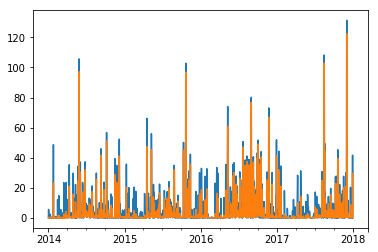

In [44]:
catchment_rainfall[1].plot()
catchment_runoff[1].plot()

### Exploring the results

We can find out about a particular results set by querying for models, variables and dimensions

In [45]:
results.models()

['DepthToRate', 'EmcDwc', 'LumpedConstituentRouting', 'Muskingum', 'Simhyd']

In [46]:
results.variables_for('EmcDwc')

['quickflow', 'baseflow', 'quickLoad', 'slowLoad', 'totalLoad']

In [47]:
results.dims_for_model('EmcDwc')

['cgu', 'constituent', 'catchment']

In [48]:
results.dim('cgu')

['Dryland',
 'Forest',
 'Horticulture',
 'Industry',
 'Irrigated Grazing',
 'Irrigation',
 'Mine/Quarry',
 'Plantation',
 'Public Land',
 'Rural Residential',
 'Urban',
 'Water/lakes']